# Herramienta Geo Estadística para el Seguimiento de la Deforestación de la Procuraduría General de la Nación (HGESD-PGN)

In [38]:
# Librerias a usar
import os
import shutil
import pandas as pd
import geopandas as gpd
import fiona
fiona.drvsupport.supported_drivers['KML'] = 'rw'

from shapely.geometry import Point
from shapely.geometry import MultiPoint
from shapely.geometry import mapping
from shapely.geometry import LineString

from pyproj import Transformer

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm

## Lectura de datos y creación de carpetas para alojar la información

In [39]:
# Trimestre a trabajar
trimestre='iv'
año='2022'

# Lectura y tratamiento de rchivos KML
ArchivoAT=f'atd_{año}_{trimestre}_trim.kml'

#Se ubica la temporalidad año_trimestre
Temporalidad=año+trimestre

gdf = gpd.read_file(ArchivoAT, driver='KML')
coords = gdf.geometry.apply(lambda p: [p.x, p.y]).tolist()

#Crear carpetas para almacenar los archivos
Carpeta_resultados='Resultados_'+Temporalidad

Carpeta_clusters=f'{Carpeta_resultados}'+'/Clusters_'+Temporalidad
Carpeta_centroide=f'{Carpeta_resultados}'+'/Centroides_'+Temporalidad
Carpeta_PoligonosMinimos=f'{Carpeta_resultados}'+'/PoligonosMinimos_'+Temporalidad
Carpeta_CirculosMáximos=f'{Carpeta_resultados}'+'/CirculosMáximos_'+Temporalidad
Carpeta_CirculosMínimos=f'{Carpeta_resultados}'+'/CirculosMínimos_'+Temporalidad
Carpeta_LineasDeTendencia=f'{Carpeta_resultados}'+'/LineasDeTendencia_'+Temporalidad

Carpeta_Graficas=f'{Carpeta_resultados}'+'/Graficas_'+Temporalidad

    # Se verifica que no existan carpetas ya creadas e información solapada
if os.path.exists(Carpeta_resultados):
    shutil.rmtree(Carpeta_resultados)
if os.path.exists(Carpeta_clusters):
    shutil.rmtree(Carpeta_clusters)
if os.path.exists(Carpeta_centroide):
    shutil.rmtree(Carpeta_centroide)
if os.path.exists(Carpeta_PoligonosMinimos):
    shutil.rmtree(Carpeta_PoligonosMinimos)
if os.path.exists(Carpeta_CirculosMáximos):
    shutil.rmtree(Carpeta_CirculosMáximos)
if os.path.exists(Carpeta_CirculosMínimos):
    shutil.rmtree(Carpeta_CirculosMínimos)
if os.path.exists(Carpeta_LineasDeTendencia):
    shutil.rmtree(Carpeta_LineasDeTendencia)
if os.path.exists(Carpeta_Graficas):
    shutil.rmtree(Carpeta_Graficas)

    #Se crean nuevas carpetas con las información
if Carpeta_resultados not in os.listdir():
    os.mkdir(Carpeta_resultados)
if Carpeta_clusters not in os.listdir():
    os.mkdir(Carpeta_clusters)
if Carpeta_centroide not in os.listdir():
    os.mkdir(Carpeta_centroide)
if Carpeta_PoligonosMinimos not in os.listdir():
    os.mkdir(Carpeta_PoligonosMinimos)
if Carpeta_CirculosMáximos not in os.listdir():
    os.mkdir(Carpeta_CirculosMáximos)
if Carpeta_CirculosMínimos not in os.listdir():
    os.mkdir(Carpeta_CirculosMínimos)
if Carpeta_LineasDeTendencia not in os.listdir():
    os.mkdir(Carpeta_LineasDeTendencia)
if Carpeta_Graficas not in os.listdir():
    os.mkdir(Carpeta_Graficas)

## Implementación del método de la silueta estable

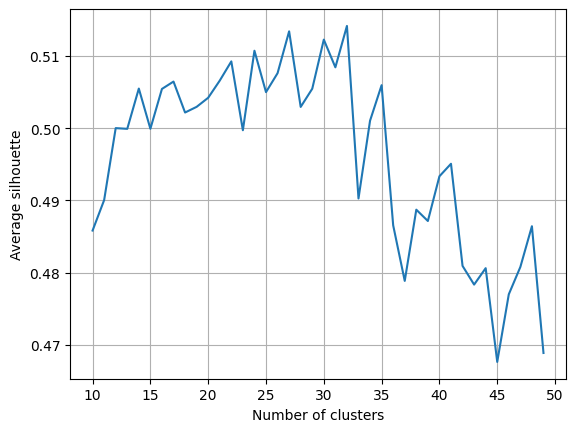

El numero sugerido de clusters, mediante el método de la silueta, es de: 32


In [40]:
# Definir un rango de valores de k
k_range = range(10, 50)

# Número de ejecuciones del algoritmo
n_init = 10

# Calcular la silueta media para cada valor de k
silhouette_scores = []
for k in k_range:
    avg_silhouette = 0
    for _ in range(n_init):
        kmeans = KMeans(n_clusters=k, n_init=1)  # n_init=1 para evitar inicialización aleatoria
        labels = kmeans.fit_predict(coords)
        avg_silhouette += silhouette_score(coords, labels)
    silhouette_scores.append(avg_silhouette / n_init)

# Resto del código para graficar y guardar la curva de la silueta
# Graficar la curva de la silueta
plt.plot(k_range, silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Average silhouette')
plt.grid()
plt.savefig(f'{Carpeta_Graficas}/Metodo de la silueta_{Temporalidad}.png', dpi=300)
plt.show()

rtaMS=pd.DataFrame()
rtaMS['Silueta media']=silhouette_scores
rtaMS['Numero de clusters']=k_range


MaxMS=[]
for i in range(1,len(silhouette_scores)-2): 
    if silhouette_scores[i]>silhouette_scores[i-1] and silhouette_scores[i]>silhouette_scores[i+1]:
        MaxMS.append(silhouette_scores[i])

rtaMSF=rtaMS[rtaMS['Silueta media'].isin(MaxMS)]
rtaMSF=rtaMSF.sort_values('Silueta media',ascending=False)
rtaMSF=rtaMSF.reset_index(drop=True)

n_clusters = rtaMSF['Numero de clusters'][0]
print(f'El numero sugerido de clusters, mediante el método de la silueta, es de: {n_clusters}')

## Determinando los clusters

In [41]:
# Ejecutar el algoritmo K-means
kmeans = KMeans(n_clusters=n_clusters).fit(coords)

# Agregar las etiquetas de los clusters al GeoDataFrame
gdf['cluster'] = kmeans.labels_

# Definir la tabla de atributos
schema = {'geometry': 'Point', 'properties': {'cluster': 'int'}}

# Guardar el GeoDataFrame en un archivo tipo shape con la tabla de atributos
gdf.to_file(f'{Carpeta_clusters}/Clustering_{Temporalidad}.shp')

c:\Users\jegonzalezb.PROCURADURIA\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\jegonzalezb.PROCURADURIA\AppData\Local\Temp\ipykernel_68956\3536698860.py:11: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(f'{Carpeta_clusters}/Clustering_{Temporalidad}.shp')


## Determinando los centroides

In [42]:
# Agrupa los datos por la columna "Cluster".
grouped = gdf.groupby('cluster')

# Crea una lista para almacenar los GeoDataFrames de centroides.
centroid_gdfs = []

# Itera a través de los grupos y calcula el centroide de cada uno.
for cluster, group in grouped:
    centroid = Point(group['geometry'].unary_union.centroid)
    # Crea un nuevo GeoDataFrame para el centroide de este grupo.
    centroid_gdf = gpd.GeoDataFrame({'Cluster': [cluster], 'geometry': [centroid]}, geometry='geometry')
    centroid_gdfs.append(centroid_gdf)

# Concatena todos los GeoDataFrames de centroides en uno solo.
centroid_gdf = pd.concat(centroid_gdfs)
# Creacion del shape
Centroides=gpd.GeoDataFrame(centroid_gdf)
Centroides.to_file(f'{Carpeta_centroide}/Centroides_{Temporalidad}.shp')

Cluster=[]
CPR=[]
for i in range(0,n_clusters):
    Cluster.append(i)
    a=int(gdf[gdf['cluster']==i].shape[0])
    CPR.append(a)

CantidadDePuntosPorCluster=pd.DataFrame()
CantidadDePuntosPorCluster['Cluster']=Cluster
CantidadDePuntosPorCluster['Cantidad de puntos']=CPR
CantidadDePuntosPorCluster['%']=round(CantidadDePuntosPorCluster['Cantidad de puntos']/gdf.shape[0]*100,2)
CantidadDePuntosPorCluster=CantidadDePuntosPorCluster.sort_values('Cantidad de puntos',ascending=False )
CantidadDePuntosPorCluster.to_csv(f'ClustersYRegistros_{Temporalidad}.txt', sep='\t', index=False)

## Polígonos mínimos

In [43]:
PoligonosDeClusters=[]
for i in Cluster:
    Puntos=gdf[gdf['cluster']==i]
    convex_hull = Puntos.unary_union.convex_hull
    convex_hull = gpd.GeoDataFrame(geometry=[convex_hull], crs="EPSG:4326")
    PoligonosDeClusters.append(convex_hull)

Poligonos = gpd.GeoDataFrame(pd.concat(PoligonosDeClusters, ignore_index=True), crs="EPSG:4326")
Poligonos.to_file(f'{Carpeta_PoligonosMinimos}/PoligonosMinimos_{Temporalidad}.shp')

## Distancias al centroide e histogramas

In [ ]:
# Calculo de las distancias de los puntos a los centroides
gdf['distancia_al_centroide'] = gdf.apply(lambda row: row['geometry'].distance(centroid_gdf[centroid_gdf['Cluster'] == row['cluster']]['geometry'].values[0]), axis=1)

radios_r=[]
radios_R=[]

Sigma=[]
Mu=[]
error=[]

for cluster in range(0,centroid_gdf['Cluster'].shape[0]):
    cluster_data = gdf[gdf['cluster'] == cluster]['distancia_al_centroide']
    # Ajuste Gaussiano
    mu, std = norm.fit(cluster_data)
    # Crear un rango de valores para la curva ajustada
    x = np.linspace(min(cluster_data), max(cluster_data), 1000)
    # Calcular la PDF ajustada
    pdf_fit = norm.pdf(x, mu, std)

    fitted_values = norm.pdf(cluster_data, loc=mu, scale=std)

    # Asegurarse de que ambos conjuntos de datos tengan la misma longitud
    min_length = min(len(cluster_data), len(fitted_values))
    cluster_data = cluster_data[:min_length]
    fitted_values = fitted_values[:min_length]

    # Calcular el error cuadrático medio (MSE)
    mse = mean_squared_error(cluster_data, fitted_values)    

    # Determinando radios a partir del ajuste
    R=mu+std
    radios_R.append(R)
    r=mu-std
    radios_r.append(r)

    Mu.append(mu)
    Sigma.append(std)
    error.append(mse)

    # Graficas
    plt.hist(cluster_data, bins=int(len(cluster_data)/10), density=True, alpha=0.7, label=f'Cluster {cluster}')
    plt.plot(x, pdf_fit, 'r-', label='Gaussian Fit')
    # Configurar el gráfico
    plt.xlabel('Distance to the Centroid')
    plt.ylabel('Frequency')
    plt.grid()
    plt.legend()
    # Mostrar los histogramas
    plt.savefig(f'{Carpeta_Graficas}/Histograma de longitudes_Cluster {cluster}.png', dpi=300)
    plt.show()

centroid_gdf['Radio superior']=radios_R
centroid_gdf['Radio inferior']=radios_r

DelAjuste=pd.DataFrame()
DelAjuste['Sigma']=Sigma
DelAjuste['Mu']=Mu

## Clustering a pares sigma mu

In [ ]:
# Ajusta 'n_clusters' según el número de clusters que deseas (en este caso, 3)
n_clusters = 3

# Selecciona las columnas que serán utilizadas para el clustering
X = DelAjuste[['Sigma', 'Mu']]

# Entrenar el modelo de K-Means
kmeans = KMeans(n_clusters=n_clusters)
DelAjuste['cluster'] = kmeans.fit_predict(X)  # Agregar la columna 'cluster' al DataFrame con las etiquetas de cluster

# Graficar los datos por cluster
for cluster_id in range(n_clusters):
    cluster_data = DelAjuste[DelAjuste['cluster'] == cluster_id]
    plt.scatter(cluster_data['Mu'],cluster_data['Sigma'], label=f'Cluster {cluster_id}')

# Graficar los datos y la línea de ajuste lineal
plt.ylabel(r'$\sigma$')
plt.xlabel(r'$\mu$')
plt.legend()
plt.savefig(f'{Carpeta_Graficas}/SigmaMu.png', dpi=300)
plt.show()

DelAjuste[['Sigma', 'Mu']].to_latex(f'TablaLatexDatosEstadisticos_{Temporalidad}')

## Consolidado de información

In [46]:
CI=pd.DataFrame()
CI['Cluster']=Cluster
CI['Cantidad de puntos']=CPR
CI['a']=CI['Cantidad de puntos']/sum(CPR)
CI['Sigma']=Sigma
CI['Mu']=Mu
CI['MSE']=error
CI['varianza']=(CI['Sigma'])**2
CI['Energia promedio']=1/2*CI['varianza']*CI['a']
CI['Energia promedio normal']=CI['Energia promedio']/sum(CI['Energia promedio'])*100
CI.reset_index(drop=True)
CI.to_latex(f'DatosEstadisticos{Temporalidad}')

## Circunferencias de probabilidad

In [47]:
# Crear una nueva columna con los círculos
centroid_gdf['Circulo R'] = centroid_gdf.apply(lambda row: row['geometry'].buffer(row['Radio superior']), axis=1)
centroid_gdf['Circulo r'] = centroid_gdf.apply(lambda row: row['geometry'].buffer(row['Radio inferior']), axis=1)
centroid_gdf['Energia promedio normal']=list(CI['Energia promedio normal'])
# Crear un GeoDataFrame con los círculos

circulos_R = gpd.GeoDataFrame(centroid_gdf[['Cluster', 'Circulo R','Energia promedio normal']], geometry='Circulo R')
circulos_r = gpd.GeoDataFrame(centroid_gdf[['Cluster', 'Circulo r','Energia promedio normal']], geometry='Circulo r')


# Guardar los círculos en un archivo tipo shape
circulos_R.to_file(f'{Carpeta_CirculosMáximos}/CM_{Temporalidad}.shp')
circulos_r.to_file(f'{Carpeta_CirculosMínimos}/Cm_{Temporalidad}.shp')

C:\Users\jegonzalezb.PROCURADURIA\AppData\Local\Temp\ipykernel_68956\805210666.py:12: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  circulos_R.to_file(f'{Carpeta_CirculosMáximos}/CM_{Temporalidad}.shp')
C:\Users\jegonzalezb.PROCURADURIA\AppData\Local\Temp\ipykernel_68956\805210666.py:13: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  circulos_r.to_file(f'{Carpeta_CirculosMínimos}/Cm_{Temporalidad}.shp')


## Histogramas de ángulos

In [ ]:
# En radianes
angles=[]

for clusters in range(0,centroid_gdf['Cluster'].shape[0]):
    for point in gdf[gdf['cluster'] == clusters]['geometry']: 
        centroid=centroid_gdf[centroid_gdf['Cluster'] == clusters]['geometry'].values[0]
        angle=np.arctan2(point.y - centroid.y, point.x - centroid.x)
        angles.append(angle)

gdf['Angulos respecto a su centroide']=angles

centroid_gdf['Ángulo máximo']=0.
centroid_gdf['Ángulo mínimo']=0.

for clusters in range(0, centroid_gdf['Cluster'].shape[0]):
    cluster_data = gdf[gdf['cluster'] == clusters]['Angulos respecto a su centroide']

    # Calcular el histograma
    frequencies, bin_edges, _ = plt.hist(cluster_data, bins=18, density=False, alpha=0.7, label=f'Cluster {clusters}')

    # Condición para cambiar el color
    threshold = (cluster_data.shape[0])/5
    
    for i in range(len(frequencies)):
        if frequencies[i] > threshold:

            ancho=bin_edges[i+1] - bin_edges[i]
            plt.bar(bin_edges[i], frequencies[i], width=ancho, alpha=0.7, color='red')

            centroid_gdf.iloc[clusters, centroid_gdf.columns.get_loc('Ángulo mínimo')]=bin_edges[i]
            centroid_gdf.iloc[clusters, centroid_gdf.columns.get_loc('Ángulo máximo')]=bin_edges[i]+ancho
            
            print(f"Para el cluster {clusters}, el ángulo mínimo es {round(bin_edges[i],2)} [rad], y el máximo es {round(bin_edges[i]+ancho,2)} [rad]")


    # Configurar el gráfico
    plt.xlabel('Angle with respect to the Centroid')
    plt.ylabel('Frequency')
    plt.legend()
    plt.savefig(f'{Carpeta_Graficas}/Histograma de Angulos_Cluster {clusters}.png', dpi=300)
    # Mostrar los histogramas
    plt.show()   

centroid_gdf['Radio medio']=(centroid_gdf['Radio superior']+centroid_gdf['Radio inferior'])/2
centroid_gdf['Ángulo medio']=(centroid_gdf['Ángulo máximo']+centroid_gdf['Ángulo mínimo'])/2

## Creación de vectores de ángulos preferentes

In [49]:
def create_lines(row):
    x0, y0 = row['geometry'].x, row['geometry'].y
    angulo = row['Ángulo medio']
    radio = row['Radio medio']
    
    # Calcular las coordenadas finales de la línea
    x1 = x0 + radio * np.cos(angulo)
    y1 = y0 + radio * np.sin(angulo)
    
    # Crear la geometría LineString
    return LineString([(x0, y0), (x1, y1)])

centroid_gdf['linea'] = centroid_gdf.apply(create_lines, axis=1)
lineas=centroid_gdf[centroid_gdf['Ángulo medio']!=0]
Lineas = gpd.GeoDataFrame(lineas[['Cluster', 'linea']], geometry='linea')

Lineas.to_file(f'{Carpeta_LineasDeTendencia}/LineasDeTendencia_{Temporalidad}.shp')